1. Import Dependencies

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

2. Load the dataset

In [ ]:
df=pd.read_csv("wine-reviews.csv", usecols=['country','description', 'points','price','variety','winery'])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


In [ ]:
df=df.dropna(subset=["description","points"])

In [ ]:
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


3. Data visualistaion ( Description and Points )

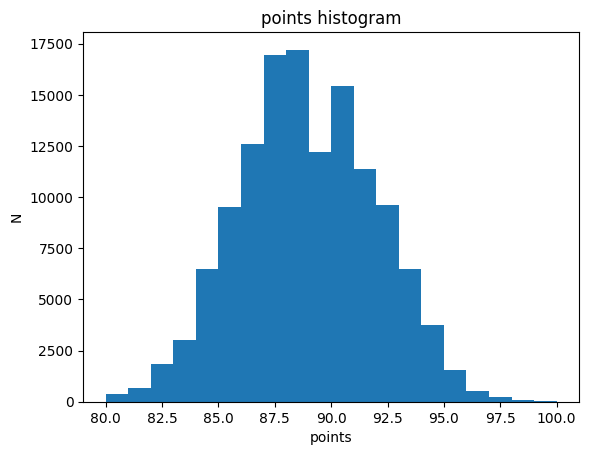

In [ ]:
plt.hist(df.points,bins=20)
plt.title("points histogram")
plt.xlabel("points")
plt.ylabel("N")
plt.show()

In [ ]:
df["label"]= (df.points >= 89).astype(int)
df =df[["label","description"]]

In [ ]:
df.tail()


,label,description
129966,1,Notes of honeysuckle and cantaloupe sweeten th...
129967,1,Citation is given as much as a decade of bottl...
129968,1,Well-drained gravel soil gives this wine its c...
129969,1,"A dry style of Pinot Gris, this is crisp with ..."
129970,1,"Big, rich and off-dry, this is powered by inte..."


4. Split the dataset and train it

In [ ]:
train, val, test = np.split(df.sample(frac=1),[int(0.8*len(df)),int(0.9*len(df))])

In [ ]:
def df_to_dataset(dataframe, shuffle=True, batch_size=1024):
  df=dataframe.copy()
  labels= df.pop("label")
  df=df["description"]
  ds=tf.data.Dataset.from_tensor_slices((df,labels))
  if shuffle:
    ds=ds.shuffle(buffer_size=len(dataframe))
  ds=ds.batch(batch_size)
  ds=ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [ ]:
len(train),len(val),len(test)

(103976, 12997, 12998)

In [ ]:
train.shape, val.shape,test.shape

((103976, 3), (12997, 3), (12998, 3))

In [ ]:
train_data = df_to_dataset(train)
valid_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [ ]:
list(train_data)[0]

(<tf.Tensor: shape=(1024,), dtype=string, numpy=
 array([b"Intense acidity precedes the ripe yellow fruits of this bright wine. It has a rich texture that's very minerally and steely, pairing with a vanilla note from its wood aging. It's a wine to be consumed young, over the next 2\xe2\x80\x933 years.",
        b'Ah, Tignanello, the father of all super Tuscans. A tried and true favorite, it is a Sangiovese-based wine cut with a small component of Cabernet for rich aromas of red fruit and spice. It is elegant, harmonious and long-lasting on the finish; drink after 2012.',
        b'Fairly neutral smelling, this feels fresh and not cloying. Lychee and honeydew flavors are basic and composed, while the finish is short.',
        ...,
        b'Apple and stone-fruit aromas are clean and presentable. This is fresh and spritzy, with flavors of lemon-lime and quince. A crisp, minerally finish runs long courtesy of pumped-up acidity.',
        b"This organically grown blend of Touriga Nacional

# 5.using tensorflow hub (embedding model)
##### embedding description into vectors

In [ ]:
embedding=("https://tfhub.dev/google/nnlm-en-dim128/2")
hub_layer=hub.KerasLayer(embedding, dtype=tf.string , trainable=True)

In [ ]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 128), dtype=float32, numpy=
array([[ 0.5673894 , -0.1853024 ,  0.15997733, ..., -0.05384406,
        -0.01115896,  0.05243442],
       [ 0.3777946 , -0.19290727,  0.1295279 , ...,  0.01896073,
         0.00859474, -0.10481865],
       [ 0.37539378, -0.2722396 ,  0.12104014, ..., -0.16805604,
        -0.00766422,  0.11467782],
       ...,
       [ 0.46685544, -0.15401582,  0.15195706, ..., -0.05089734,
        -0.12927508, -0.01397158],
       [ 0.29136512, -0.27946272,  0.17003365, ..., -0.14250605,
         0.14252853, -0.05173935],
       [ 0.37695518, -0.08760593,  0.02056231, ..., -0.14668334,
        -0.04680004,  0.03467334]], dtype=float32)>

6. Build the model

In [ ]:
model= tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16,activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.evaluate(train_data)

102/102 [==============================] - 47s 449ms/step - loss: 0.6990 - accuracy: 0.4710


[0.6989921927452087, 0.4710029363632202]

In [ ]:
model.evaluate(valid_data)

13/13 [==============================] - 6s 466ms/step - loss: 0.7029 - accuracy: 0.4680


[0.7029101848602295, 0.4680310785770416]

7. Train the model

In [ ]:
history=model.fit(train_data,epochs=5 ,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 373s 4s/step - loss: 0.3260 - accuracy: 0.8694 - val_loss: 0.4284 - val_accuracy: 0.8127
Epoch 2/5
102/102 [==============================] - 380s 4s/step - loss: 0.3070 - accuracy: 0.8764 - val_loss: 0.4435 - val_accuracy: 0.8127
Epoch 3/5
102/102 [==============================] - 384s 4s/step - loss: 0.2934 - accuracy: 0.8833 - val_loss: 0.4658 - val_accuracy: 0.8127
Epoch 4/5
102/102 [==============================] - 362s 4s/step - loss: 0.2769 - accuracy: 0.8888 - val_loss: 0.4824 - val_accuracy: 0.8100
Epoch 5/5
102/102 [==============================] - 383s 4s/step - loss: 0.2599 - accuracy: 0.8951 - val_loss: 0.4971 - val_accuracy: 0.8107


8. plot the Accuracy and Loss Graph

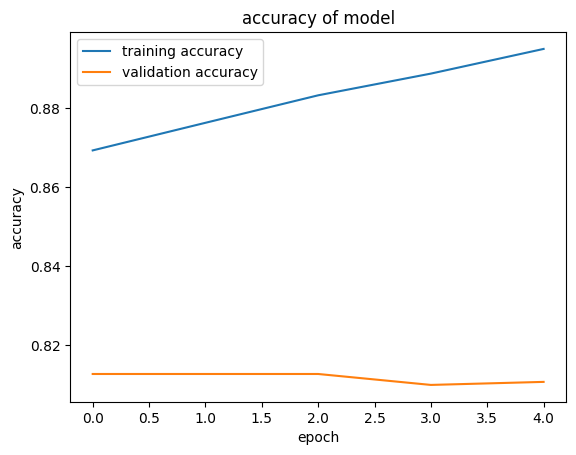

In [ ]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.title("accuracy of model")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

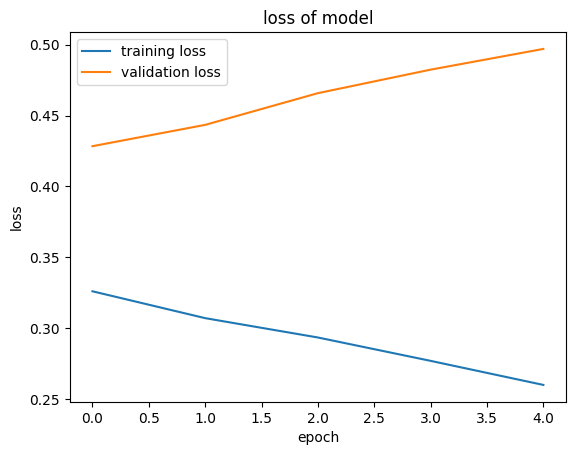

In [ ]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.title("loss of model")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

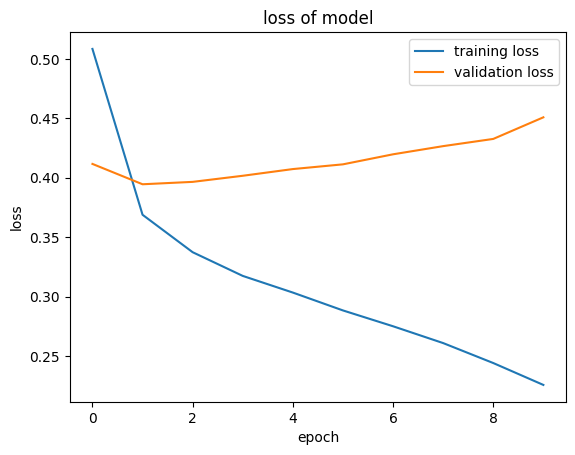

In [ ]:
plt.plot(history.history["loss"],label="training loss")
plt.plot(history.history["val_loss"],label="validation loss")
plt.title("loss of model")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

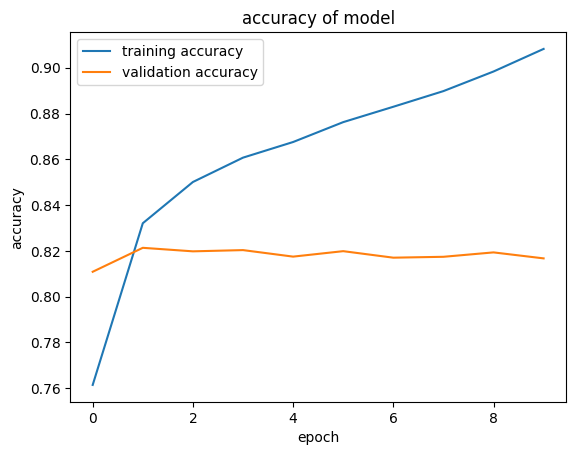

In [ ]:
plt.plot(history.history["accuracy"],label="training accuracy")
plt.plot(history.history["val_accuracy"],label="validation accuracy")
plt.title("accuracy of model")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 11s 859ms/step - loss: 0.4920 - accuracy: 0.8134


[0.491971492767334, 0.8134328126907349]

#  LSTM (ALternative of Tensorflowhub embedding Model)

9. Text embedding

In [ ]:
encoder=tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text ,label:text))

In [ ]:
vocab= np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'and', 'the', 'a', 'of', 'with', 'this', 'is', 'wine',
       'flavors', 'in', 'it', 'to', 'its', 'on', 'fruit', 'aromas',
       'palate', 'that'], dtype='<U17')

10. LSTM Model

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1,activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1,activation='sigmoid')

])

In [ ]:
model.compile(optimizer='adam',loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])


In [ ]:
model.evaluate(train_data)
model.evaluate(valid_data)

13/13 [==============================] - 2s 159ms/step - loss: 0.6930 - accuracy: 0.5321


[0.6930303573608398, 0.532122790813446]

11. Train the Model

In [ ]:
history=model.fit(train_data,epochs=5 ,validation_data=valid_data)

Epoch 1/5
102/102 [==============================] - 60s 539ms/step - loss: 0.6325 - accuracy: 0.6064 - val_loss: 0.5535 - val_accuracy: 0.8063
Epoch 2/5
102/102 [==============================] - 47s 462ms/step - loss: 0.5835 - accuracy: 0.6776 - val_loss: 0.5212 - val_accuracy: 0.8188
Epoch 3/5
102/102 [==============================] - 50s 492ms/step - loss: 0.5720 - accuracy: 0.6849 - val_loss: 0.5001 - val_accuracy: 0.8226
Epoch 4/5
102/102 [==============================] - 46s 442ms/step - loss: 0.5683 - accuracy: 0.6856 - val_loss: 0.4872 - val_accuracy: 0.8222
Epoch 5/5
102/102 [==============================] - 46s 450ms/step - loss: 0.5669 - accuracy: 0.6851 - val_loss: 0.4867 - val_accuracy: 0.8222


In [ ]:
model.evaluate(test_data)

13/13 [==============================] - 2s 158ms/step - loss: 0.4888 - accuracy: 0.8254


[0.48876067996025085, 0.8253577351570129]